In [1]:
using Agents , Random , InteractiveDynamics , CairoMakie 
using DrWatson: @dict
using DataFrames , Plots, Distributions


mutable struct Agent2 <: AbstractAgent
    id::Int
    pos::NTuple{2,Float64}
    vel::NTuple{2,Float64}
    mass::Float64
    days_infected::Int # how many days have passed after infection
    status::Symbol # :S (susceptible), :I (infecious), :R (removed, immune), :Q (quarantine and infecious) 
    days_quarantine::Int
    hygiene::Float64
end


function symulation(;
    infection_period = 24 ,
    detection_time = 14 ,
    reinfection_probability = 0.01,
    isolated = 0.2, # 0 is nobody is isolated , 1 everyone is isolated
    interaction_radius = 0.01,
    dt = 1,
    speed = 0.0012,
    death_rate = 0.044,
    N = 1000,
    initial_infected = 5,
    seed = 1410,
    hygiene_min = 0.4,
    hygiene_max = 0.8,
    time_of_quarantine = 10,
    steps_per_day = 12,
    chance_to_go_quaratine = 0.5
    )

    infection_period *= steps_per_day
    detection_time *=  steps_per_day
    time_of_quarantine *= steps_per_day

    properties = @dict(
        infection_period,
        detection_time,
        reinfection_probability,
        death_rate,
        dt,
        interaction_radius,
        time_of_quarantine,
        speed,
        chance_to_go_quaratine,
        steps_per_day,
        
    )

    space = ContinuousSpace((1,1), 0.02)
    model = ABM(Agent2,space, properties = properties, rng = MersenneTwister(seed))

    # Add agents to the model
    
    for idx in 1:N
        pos = Tuple(rand(model.rng, 2))
        status = idx > initial_infected ? :S : :I
        is_isolated = rand(model.rng, Categorical([isolated,1-isolated])) == 1 ? true : false 
        mass = is_isolated ? Inf : 1.0
        vel = is_isolated ? (0,0) : sincos(2pi* rand(model.rng,)) .* speed
        hygiene = (hygiene_max-hygiene_min)*rand(model.rng) + hygiene_min
        add_agent!(pos,model,vel, mass, 0, status, 0, hygiene)
    end
    return model
end

function transmit!(a,b,reinfection,model)
    if  count(a.status == :I for a in (a,b)) in (0,2)
        return
    end
    
    infected, healthy = a.status == :I ? (a,b) : (b,a)
    rand(model.rng) < (infected.hygiene + healthy.hygiene)/2 && return 

   
    if healthy.status == :R
        if rand(model.rng) > reinfection 
            return
        end
    end

    healthy.status = :I
end

function model_step!(model)
    r = model.interaction_radius
    for (a, b) in interacting_pairs(model, r, :nearest)
        transmit!(a,b,model.reinfection_probability,model)
        elastic_collision!(a, b, :mass)
    end
end

function quarantine!(a,model)
    if a.status == :I && a.days_infected >= model.detection_time && rand(model.rng) < model.chance_to_go_quaratine / model.steps_per_day
        a.status = :Q
        a.vel = (0,0)
        a.mass = Inf

    end
end

function quarantine_end!(a,model)
    if a.days_quarantine == model.time_of_quarantine
        a.days_quarantine = 0
        recover_or_die!(a,model) 
        a.vel = sincos(2pi* rand(model.rng,)) .* model.speed
        a.mass = 1.0
    end
end

function recover_or_die!(agent, model)
    if agent.days_infected >= model.infection_period
        if rand(model.rng) <= model.death_rate
            kill_agent!(agent, model)
        else 
            agent.status = :R
            agent.days_infected = 0
        end
    end
end

function agent_step!(agent,model)
    move_agent!(agent, model, model.dt)
    agent.status in (:I,:Q) ? agent.days_infected +=1 : agent.days_infected = 0
    agent.status == :Q ? agent.days_quarantine +=1 : agent.days_quarantine = 0
    recover_or_die!(agent, model)
    quarantine!(agent,model)
    quarantine_end!(agent,model)
end
sir_colors(a) = a.status == :S ? "#000000" : a.status == :I ? "#FF0000" : a.status == :Q ? "#00FFFF" : "#00FF00"
# black, red, cyan, green

sir_colors (generic function with 1 method)

In [2]:
using Distributions
rand(Categorical([0.8,1-0.8]), 10)

10-element Vector{Int64}:
 1
 1
 2
 1
 2
 1
 1
 1
 2
 1

In [3]:
sir_model = symulation(isolated = 0 )

abm_video("symolation_without_isolation.mp4",
    sir_model,
    agent_step!,
    model_step!,
    title = " Symulation",
    ac = sir_colors,
    frames = 500 , spf = 2, framerate = 25)



In [4]:
using JLD2
#an aggregating functions
susceptible(x) = count(i == :S for i in x)
recovered(x) = count(i == :R for i in x)
infected(x) = count(i in [:I,:Q] for i in x)

sir_model1 = symulation(isolated = 0.8)
sir_model2 = symulation(isolated = 1)
sir_model3 = symulation(isolated = 0.4)
sir_model4 = symulation(isolated = 0)

adata = [(:status, susceptible), (:status, recovered), (:status, infected)]
Threads.@spawn global   agents1_df, = run!(sir_model1, agent_step!, model_step!, 1000; adata)
Threads.@spawn global   agents2_df, = run!(sir_model2, agent_step!, model_step!, 1000; adata)
Threads.@spawn global   agents3_df, = run!(sir_model3, agent_step!, model_step!, 1000; adata)
Threads.@spawn global   agents4_df, = run!(sir_model4, agent_step!, model_step!, 1000; adata)

sir_modela = symulation(isolated = 0.8, hygiene_max = 0.8, hygiene_min = 0.7)
sir_modelb = symulation(isolated = 0.8, hygiene_max = 0.8, hygiene_min = 0.5)
sir_modelc = symulation(isolated = 0.8, hygiene_max = 0.8, hygiene_min = 0.3)
sir_modeld = symulation(isolated = 0.8, hygiene_max = 0.8, hygiene_min = 0.0)


Threads.@spawn global   agentsa, = run!(sir_modela, agent_step!, model_step!, 1000; adata)
Threads.@spawn global   agentsb, = run!(sir_modelb, agent_step!, model_step!, 1000; adata)
Threads.@spawn global   agentsc, = run!(sir_modelc, agent_step!, model_step!, 1000; adata)
Threads.@spawn global   agentsd, = run!(sir_modeld, agent_step!, model_step!, 1000; adata)


sir_model1a = symulation(isolated = 0.8, hygiene_max = 1.0,hygiene_min = 0.1)
sir_model1b = symulation(isolated = 0.8, hygiene_max = 0.8,hygiene_min = 0.1)
sir_model1c = symulation(isolated = 0.8, hygiene_max = 0.5,hygiene_min = 0.1)
sir_model1d = symulation(isolated = 0.8, hygiene_max = 0.2,hygiene_min = 0.1)

Threads.@spawn global   agents1a, = run!(sir_model1a, agent_step!, model_step!, 1000; adata)
Threads.@spawn global   agents1b, = run!(sir_model1b, agent_step!, model_step!, 1000; adata)
Threads.@spawn global   agents1c, = run!(sir_model1c, agent_step!, model_step!, 1000; adata)
Threads.@spawn global   agents1d, = run!(sir_model1d, agent_step!, model_step!, 1000; adata)


sir_modelk1 = symulation(chance_to_go_quaratine = 0, isolated = 0.6)
sir_modelk2 = symulation(chance_to_go_quaratine = 12, isolated = 0.6)

Threads.@spawn global   agentsk1, = run!(sir_modelk1, agent_step!, model_step!, 1000; adata)
Threads.@spawn global   agentsk2, = run!(sir_modelk2, agent_step!, model_step!, 1000; adata)



Task (runnable) @0x0000000085eb7210

In [5]:
using JLD2, DataFrames 
@save "izolacja.jld2" agents1_df agents2_df agents3_df agents4_df
@save "higiena_min.jld2" agentsa agentsb agentsc agentsd
@save "higiena_max.jld2" agents1a agents1b agents1c agents1d
@save "kwarantanna.jld2" agentsk1 agentsk2 

LoadError: UndefVarError: agentsa not defined

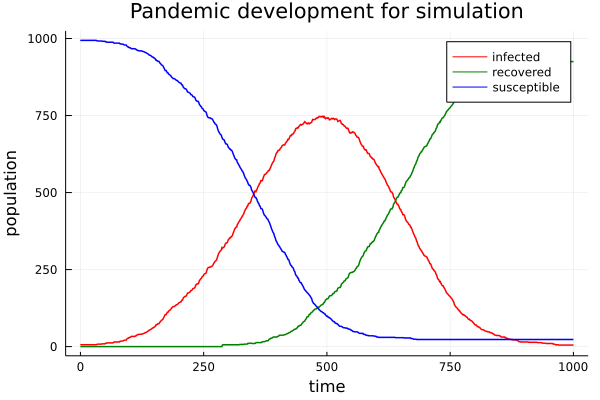

In [6]:
using JLD2, DataFrames , Plots
@load "izolacja.jld2"

x = agents3_df.step
p1 = Plots.plot(x, agents3_df[:, aggname(:status, infected)],
    linecolor = "red",
    lw = 1.5,
    xlabel = "time",
    ylabel = "population",
    label = "infected",
    title = "Pandemic development for simulation")
Plots.plot!(x, agents3_df[:, aggname(:status, recovered)],
    linecolor = :green,
    lw = 1.5,
    label = "recovered")
Plots.plot!(x, agents3_df[:, aggname(:status, susceptible)],
    linecolor = :blue,
    lw = 1.5,
    label = "susceptible")



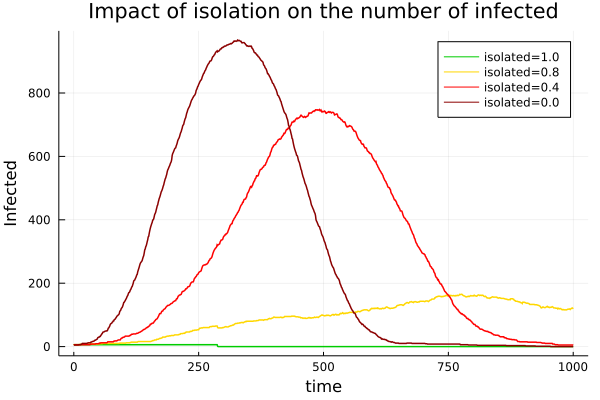

In [7]:
using JLD2, DataFrames , Plots
@load "izolacja.jld2"
x = agents1_df.step

Plots.plot(x, agents2_df[:, aggname(:status, infected)],
    linecolor = "#00CC00",
    lw = 1.5,
    ylabel = "Infected",
    xlabel = "time",
    label = "isolated=1.0",
    title = "Impact of isolation on the number of infected")
Plots.plot!(x, agents1_df[:, aggname(:status, infected)],
    linecolor = "#FFD700",
    lw = 1.5,
    label = "isolated=0.8")
Plots.plot!(x, agents3_df[:, aggname(:status, infected)],
    linecolor = "#FF0000",
    lw = 1.5,
    label = "isolated=0.4")
Plots.plot!(x, agents4_df[:, aggname(:status, infected)],
    linecolor = "#8B0000",
    lw = 1.5,
    label = "isolated=0.0")

In [8]:
using JLD2, DataFrames , Plots
@load "higiena_min.jld2"

x = agentsd.step

Plots.plot(x, agentsd[:, aggname(:status, infected)],
    linecolor = "#FFD700",
    lw = 1.5,
    ylabel = "Infected",
    xlabel = "time",
    label = "max=0.8, min=0.0",
    title = "Impact of hygiene on the number of infection",
    legendtitle = "hygiene",
    legend = :topleft)
Plots.plot!(x, agentsc[:, aggname(:status, infected)],
    linecolor = "#FF6600",
    lw = 1.5,
    label = "max=0.8, min=0.3")
Plots.plot!(x, agentsb[:, aggname(:status, infected)],
    linecolor = "#CC0000",
    lw = 1.5,
    label = "max=0.8, min=0.5")
Plots.plot!(x, agentsa[:, aggname(:status, infected)],
    linecolor = "#660033",
    lw = 1.5,
    label = "max=0.8, min=0.7")



LoadError: UndefVarError: agentsa not defined

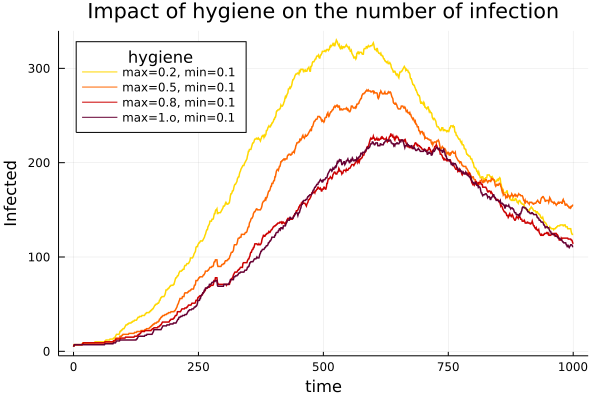

In [9]:
using JLD2, DataFrames , Plots
@load "higiena_max.jld2"

x = agents1d.step

Plots.plot(x, agents1d[:, aggname(:status, infected)],
    linecolor = "#FFD700",
    lw = 1.5,
    ylabel = "Infected",
    xlabel = "time",
    label = "max=0.2, min=0.1",
    title = "Impact of hygiene on the number of infection",
    legendtitle = "hygiene",
    legend = :topleft)
Plots.plot!(x, agents1c[:, aggname(:status, infected)],
    linecolor = "#FF6600",
    lw = 1.5,
    label = "max=0.5, min=0.1")
Plots.plot!(x, agents1b[:, aggname(:status, infected)],
    linecolor = "#CC0000",
    lw = 1.5,
    label = "max=0.8, min=0.1")
Plots.plot!(x, agents1a[:, aggname(:status, infected)],
    linecolor = "#660033",
    lw = 1.5,
    label = "max=1.o, min=0.1")

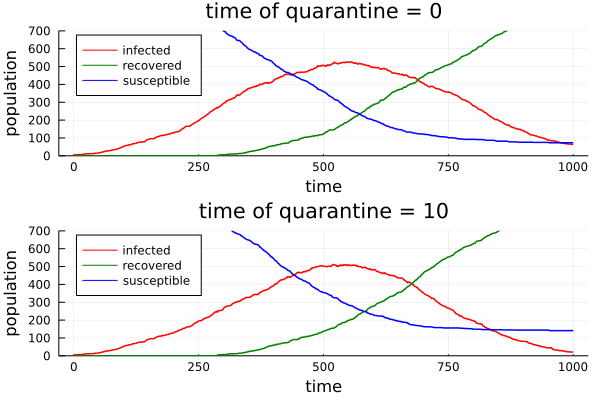

In [10]:
using JLD2, DataFrames , Plots
@load "kwarantanna.jld2"
x = agentsk1.step
pk = Plots.plot(x, agentsk1[:, aggname(:status, infected)],
    linecolor = "red",
    lw = 1.5,
    title = "time of quarantine = 0",
    xlabel = "time",
    ylabel = "population",
    label = "infected",
    ylims = (0,700),
    legend = :topleft)
Plots.plot!(x, agentsk1[:, aggname(:status, recovered)],
    linecolor = :green,
    lw = 1.5,
    label = "recovered")
Plots.plot!(x, agentsk1[:, aggname(:status, susceptible)],
    linecolor = :blue,
    lw = 1.5,
    label = "susceptible")

pk2 = Plots.plot(x, agentsk2[:, aggname(:status, infected)],
    linecolor = "red",
    lw = 1.5,
    title = "time of quarantine = 10",
    xlabel = "time",
    ylabel = "population",
    label = "infected",
    ylims = (0,700),
    legend = :topleft)
Plots.plot!(x, agentsk2[:, aggname(:status, recovered)],
    linecolor = :green,
    lw = 1.5,
    label = "recovered")
Plots.plot!(x, agentsk2[:, aggname(:status, susceptible)],
    linecolor = :blue,
    lw = 1.5,
    label = "susceptible"
    )

Plots.plot(pk, pk2, layout = (2, 1))
